In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 28
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 16

In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    
    ap_residual = AveragePooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalAveragePooling2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 32)   4704        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 32)   128         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 32)     9216        spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 32)     128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 32)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 32)     0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 32)           0           spatial_dropout2d_9[0][0]        
__________

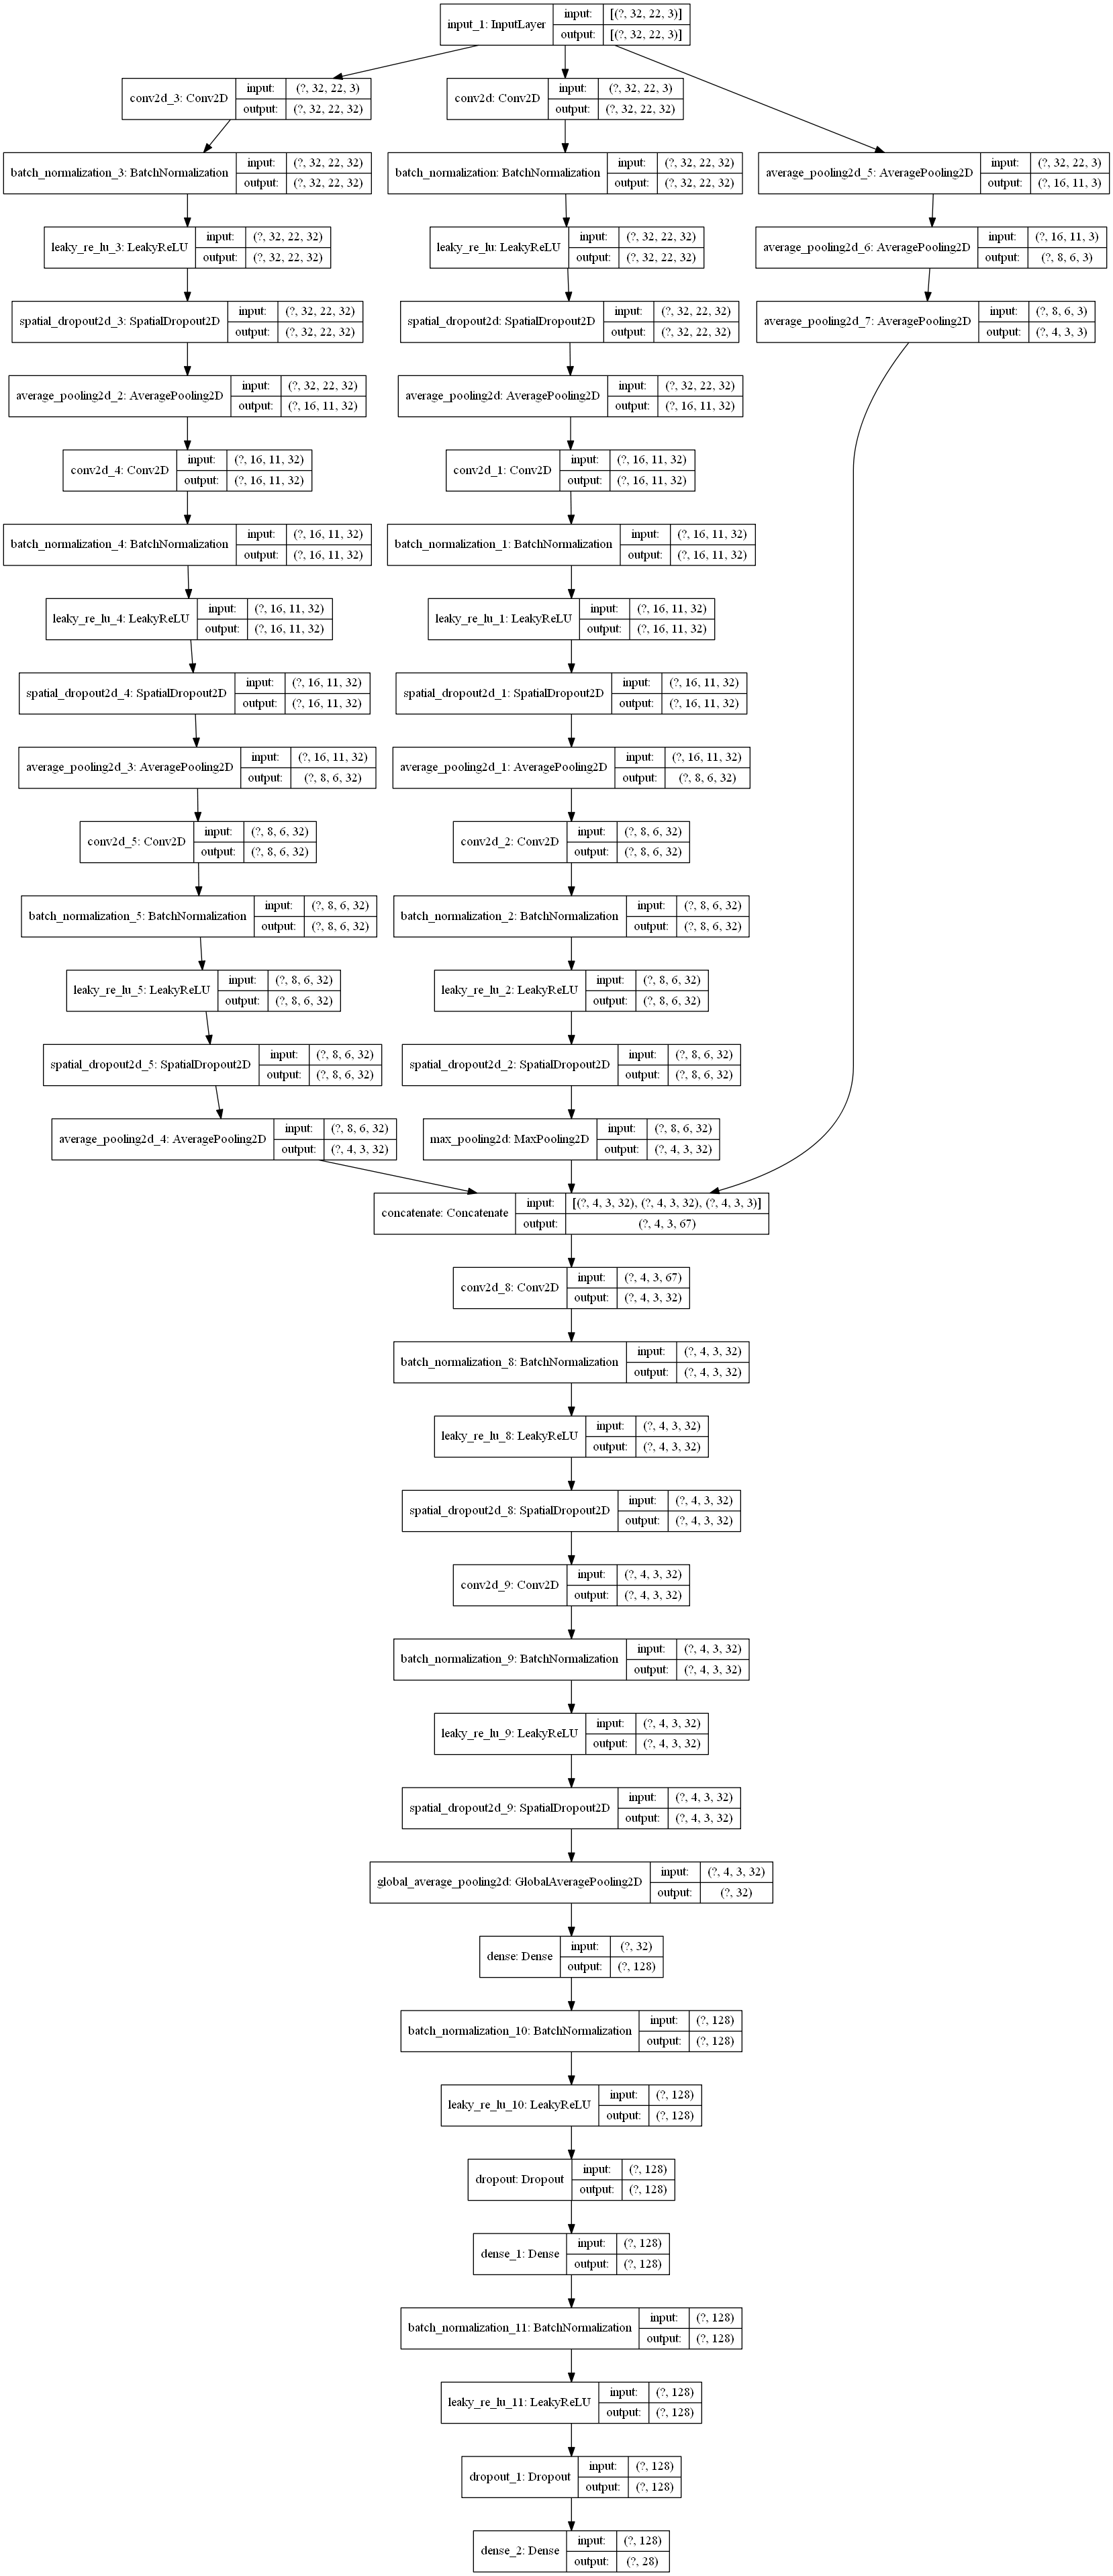

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Train['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  1%|▊                                                                              | 21/1960 [00:00<00:09, 200.53it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 205.16it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Test['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:04<00:00, 209.19it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=32, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1952/1960 [============================>.] - ETA: 1:37 - loss: 3.7535 - acc: 0.031 - ETA: 49s - loss: 3.5143 - acc: 0.078 - ETA: 33s - loss: 3.4378 - acc: 0.07 - ETA: 25s - loss: 3.4155 - acc: 0.05 - ETA: 20s - loss: 3.3994 - acc: 0.06 - ETA: 17s - loss: 3.4205 - acc: 0.05 - ETA: 15s - loss: 3.4044 - acc: 0.05 - ETA: 13s - loss: 3.3829 - acc: 0.05 - ETA: 11s - loss: 3.3559 - acc: 0.06 - ETA: 10s - loss: 3.3370 - acc: 0.07 - ETA: 9s - loss: 3.3117 - acc: 0.0795 - ETA: 9s - loss: 3.2929 - acc: 0.080 - ETA: 8s - loss: 3.2655 - acc: 0.098 - ETA: 7s - loss: 3.2543 - acc: 0.102 - ETA: 7s - loss: 3.2540 - acc: 0.097 - ETA: 6s - loss: 3.2403 - acc: 0.101 - ETA: 6s - loss: 3.2277 - acc: 0.106 - ETA: 6s - loss: 3.2257 - acc: 0.105 - ETA: 5s - loss: 3.2012 - acc: 0.106 - ETA: 5s - loss: 3.1835 - acc: 0.112 - ETA: 5s - loss: 3.1698 - acc: 0.116 - ETA: 4s - loss: 3.1422 - acc: 0.123 - ETA: 4s - loss: 3.1321 - acc: 0.119 - ETA: 4s - loss: 

1952/1960 [============================>.] - ETA: 3s - loss: 1.1349 - acc: 0.625 - ETA: 3s - loss: 1.2361 - acc: 0.562 - ETA: 3s - loss: 1.2718 - acc: 0.562 - ETA: 3s - loss: 1.2426 - acc: 0.554 - ETA: 3s - loss: 1.1774 - acc: 0.587 - ETA: 3s - loss: 1.1924 - acc: 0.599 - ETA: 3s - loss: 1.2020 - acc: 0.571 - ETA: 3s - loss: 1.2022 - acc: 0.578 - ETA: 3s - loss: 1.1854 - acc: 0.572 - ETA: 2s - loss: 1.1545 - acc: 0.593 - ETA: 2s - loss: 1.1610 - acc: 0.599 - ETA: 2s - loss: 1.1886 - acc: 0.588 - ETA: 2s - loss: 1.2064 - acc: 0.588 - ETA: 2s - loss: 1.1955 - acc: 0.598 - ETA: 2s - loss: 1.1811 - acc: 0.604 - ETA: 2s - loss: 1.1869 - acc: 0.595 - ETA: 2s - loss: 1.1903 - acc: 0.591 - ETA: 2s - loss: 1.1946 - acc: 0.590 - ETA: 2s - loss: 1.1882 - acc: 0.590 - ETA: 2s - loss: 1.1857 - acc: 0.592 - ETA: 2s - loss: 1.1775 - acc: 0.592 - ETA: 2s - loss: 1.1792 - acc: 0.589 - ETA: 2s - loss: 1.1768 - acc: 0.588 - ETA: 2s - loss: 1.1805 - acc: 0.589 - ETA: 2s - loss: 1.1855 - acc: 0.587 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.7559 - acc: 0.781 - ETA: 3s - loss: 0.7384 - acc: 0.812 - ETA: 3s - loss: 0.8267 - acc: 0.791 - ETA: 3s - loss: 0.7732 - acc: 0.796 - ETA: 3s - loss: 0.8189 - acc: 0.775 - ETA: 3s - loss: 0.8400 - acc: 0.760 - ETA: 3s - loss: 0.8551 - acc: 0.750 - ETA: 3s - loss: 0.9307 - acc: 0.722 - ETA: 2s - loss: 0.8907 - acc: 0.750 - ETA: 2s - loss: 0.8572 - acc: 0.759 - ETA: 2s - loss: 0.8663 - acc: 0.744 - ETA: 2s - loss: 0.8869 - acc: 0.734 - ETA: 2s - loss: 0.8907 - acc: 0.728 - ETA: 2s - loss: 0.9023 - acc: 0.725 - ETA: 2s - loss: 0.8950 - acc: 0.725 - ETA: 2s - loss: 0.8982 - acc: 0.720 - ETA: 2s - loss: 0.8982 - acc: 0.716 - ETA: 2s - loss: 0.8717 - acc: 0.729 - ETA: 2s - loss: 0.8585 - acc: 0.735 - ETA: 2s - loss: 0.8565 - acc: 0.739 - ETA: 2s - loss: 0.8506 - acc: 0.741 - ETA: 2s - loss: 0.8574 - acc: 0.737 - ETA: 2s - loss: 0.8502 - acc: 0.739 - ETA: 2s - loss: 0.8508 - acc: 0.739 - ETA: 2s - loss: 0.8417 - acc: 0.740 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.6391 - acc: 0.843 - ETA: 3s - loss: 0.5974 - acc: 0.828 - ETA: 3s - loss: 0.6315 - acc: 0.812 - ETA: 3s - loss: 0.6635 - acc: 0.796 - ETA: 3s - loss: 0.6505 - acc: 0.793 - ETA: 3s - loss: 0.6592 - acc: 0.781 - ETA: 3s - loss: 0.6484 - acc: 0.785 - ETA: 3s - loss: 0.6335 - acc: 0.789 - ETA: 3s - loss: 0.6325 - acc: 0.784 - ETA: 2s - loss: 0.6232 - acc: 0.793 - ETA: 2s - loss: 0.6450 - acc: 0.781 - ETA: 2s - loss: 0.6517 - acc: 0.773 - ETA: 2s - loss: 0.6530 - acc: 0.774 - ETA: 2s - loss: 0.6661 - acc: 0.770 - ETA: 2s - loss: 0.6687 - acc: 0.775 - ETA: 2s - loss: 0.6793 - acc: 0.769 - ETA: 2s - loss: 0.6667 - acc: 0.775 - ETA: 2s - loss: 0.6650 - acc: 0.783 - ETA: 2s - loss: 0.6767 - acc: 0.781 - ETA: 2s - loss: 0.6834 - acc: 0.778 - ETA: 2s - loss: 0.6819 - acc: 0.778 - ETA: 2s - loss: 0.6772 - acc: 0.778 - ETA: 2s - loss: 0.6739 - acc: 0.782 - ETA: 2s - loss: 0.6758 - acc: 0.779 - ETA: 2s - loss: 0.6875 - acc: 0.777 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.4475 - acc: 0.843 - ETA: 3s - loss: 0.5495 - acc: 0.843 - ETA: 3s - loss: 0.5294 - acc: 0.833 - ETA: 3s - loss: 0.5565 - acc: 0.820 - ETA: 3s - loss: 0.5321 - acc: 0.825 - ETA: 3s - loss: 0.5719 - acc: 0.828 - ETA: 3s - loss: 0.5844 - acc: 0.817 - ETA: 2s - loss: 0.5802 - acc: 0.820 - ETA: 2s - loss: 0.5998 - acc: 0.812 - ETA: 2s - loss: 0.5924 - acc: 0.806 - ETA: 2s - loss: 0.5887 - acc: 0.806 - ETA: 2s - loss: 0.5832 - acc: 0.815 - ETA: 2s - loss: 0.5858 - acc: 0.812 - ETA: 2s - loss: 0.5722 - acc: 0.817 - ETA: 2s - loss: 0.5814 - acc: 0.820 - ETA: 2s - loss: 0.5650 - acc: 0.824 - ETA: 2s - loss: 0.5541 - acc: 0.827 - ETA: 2s - loss: 0.5508 - acc: 0.828 - ETA: 2s - loss: 0.5510 - acc: 0.824 - ETA: 2s - loss: 0.5392 - acc: 0.829 - ETA: 2s - loss: 0.5562 - acc: 0.821 - ETA: 2s - loss: 0.5588 - acc: 0.821 - ETA: 2s - loss: 0.5549 - acc: 0.822 - ETA: 2s - loss: 0.5521 - acc: 0.821 - ETA: 2s - loss: 0.5472 - acc: 0.825 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.5623 - acc: 0.812 - ETA: 3s - loss: 0.4023 - acc: 0.875 - ETA: 3s - loss: 0.3735 - acc: 0.895 - ETA: 3s - loss: 0.3919 - acc: 0.882 - ETA: 3s - loss: 0.4262 - acc: 0.875 - ETA: 3s - loss: 0.4269 - acc: 0.864 - ETA: 2s - loss: 0.4474 - acc: 0.861 - ETA: 2s - loss: 0.4340 - acc: 0.867 - ETA: 2s - loss: 0.4258 - acc: 0.871 - ETA: 2s - loss: 0.4377 - acc: 0.868 - ETA: 2s - loss: 0.4219 - acc: 0.872 - ETA: 2s - loss: 0.4522 - acc: 0.864 - ETA: 2s - loss: 0.4572 - acc: 0.855 - ETA: 2s - loss: 0.4596 - acc: 0.852 - ETA: 2s - loss: 0.4608 - acc: 0.852 - ETA: 2s - loss: 0.4662 - acc: 0.851 - ETA: 2s - loss: 0.4608 - acc: 0.852 - ETA: 2s - loss: 0.4567 - acc: 0.854 - ETA: 2s - loss: 0.4534 - acc: 0.855 - ETA: 2s - loss: 0.4638 - acc: 0.850 - ETA: 2s - loss: 0.4548 - acc: 0.851 - ETA: 2s - loss: 0.4491 - acc: 0.855 - ETA: 2s - loss: 0.4483 - acc: 0.854 - ETA: 2s - loss: 0.4420 - acc: 0.859 - ETA: 1s - loss: 0.4411 - acc: 0.856 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.2762 - acc: 0.875 - ETA: 3s - loss: 0.3366 - acc: 0.906 - ETA: 3s - loss: 0.3690 - acc: 0.895 - ETA: 3s - loss: 0.3664 - acc: 0.875 - ETA: 3s - loss: 0.4028 - acc: 0.862 - ETA: 3s - loss: 0.4450 - acc: 0.859 - ETA: 2s - loss: 0.4538 - acc: 0.866 - ETA: 2s - loss: 0.4410 - acc: 0.867 - ETA: 2s - loss: 0.4370 - acc: 0.864 - ETA: 2s - loss: 0.4158 - acc: 0.868 - ETA: 2s - loss: 0.4210 - acc: 0.863 - ETA: 2s - loss: 0.4221 - acc: 0.859 - ETA: 2s - loss: 0.4179 - acc: 0.860 - ETA: 2s - loss: 0.4278 - acc: 0.859 - ETA: 2s - loss: 0.4239 - acc: 0.864 - ETA: 2s - loss: 0.4309 - acc: 0.863 - ETA: 2s - loss: 0.4228 - acc: 0.865 - ETA: 2s - loss: 0.4327 - acc: 0.862 - ETA: 2s - loss: 0.4229 - acc: 0.868 - ETA: 2s - loss: 0.4100 - acc: 0.871 - ETA: 2s - loss: 0.4052 - acc: 0.870 - ETA: 2s - loss: 0.3987 - acc: 0.872 - ETA: 2s - loss: 0.3989 - acc: 0.872 - ETA: 2s - loss: 0.3982 - acc: 0.869 - ETA: 1s - loss: 0.3945 - acc: 0.872 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.3113 - acc: 0.875 - ETA: 3s - loss: 0.3894 - acc: 0.875 - ETA: 3s - loss: 0.4417 - acc: 0.885 - ETA: 3s - loss: 0.3760 - acc: 0.906 - ETA: 3s - loss: 0.3868 - acc: 0.906 - ETA: 3s - loss: 0.4256 - acc: 0.890 - ETA: 2s - loss: 0.4331 - acc: 0.879 - ETA: 2s - loss: 0.4185 - acc: 0.875 - ETA: 2s - loss: 0.4154 - acc: 0.871 - ETA: 2s - loss: 0.4105 - acc: 0.868 - ETA: 2s - loss: 0.3915 - acc: 0.875 - ETA: 2s - loss: 0.3958 - acc: 0.877 - ETA: 2s - loss: 0.3926 - acc: 0.879 - ETA: 2s - loss: 0.3783 - acc: 0.886 - ETA: 2s - loss: 0.3674 - acc: 0.891 - ETA: 2s - loss: 0.3699 - acc: 0.888 - ETA: 2s - loss: 0.3607 - acc: 0.891 - ETA: 2s - loss: 0.3550 - acc: 0.890 - ETA: 2s - loss: 0.3571 - acc: 0.888 - ETA: 2s - loss: 0.3523 - acc: 0.890 - ETA: 2s - loss: 0.3696 - acc: 0.885 - ETA: 2s - loss: 0.3707 - acc: 0.884 - ETA: 2s - loss: 0.3622 - acc: 0.887 - ETA: 2s - loss: 0.3555 - acc: 0.890 - ETA: 2s - loss: 0.3523 - acc: 0.891 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.4934 - acc: 0.812 - ETA: 3s - loss: 0.3598 - acc: 0.859 - ETA: 3s - loss: 0.3631 - acc: 0.864 - ETA: 3s - loss: 0.3303 - acc: 0.882 - ETA: 3s - loss: 0.3116 - acc: 0.887 - ETA: 3s - loss: 0.3125 - acc: 0.890 - ETA: 3s - loss: 0.2924 - acc: 0.901 - ETA: 3s - loss: 0.2933 - acc: 0.906 - ETA: 3s - loss: 0.2847 - acc: 0.913 - ETA: 2s - loss: 0.3001 - acc: 0.906 - ETA: 2s - loss: 0.2899 - acc: 0.909 - ETA: 2s - loss: 0.2839 - acc: 0.906 - ETA: 2s - loss: 0.2819 - acc: 0.906 - ETA: 2s - loss: 0.2855 - acc: 0.904 - ETA: 2s - loss: 0.2912 - acc: 0.895 - ETA: 2s - loss: 0.2803 - acc: 0.900 - ETA: 2s - loss: 0.2821 - acc: 0.898 - ETA: 2s - loss: 0.2951 - acc: 0.894 - ETA: 2s - loss: 0.3116 - acc: 0.889 - ETA: 2s - loss: 0.3038 - acc: 0.895 - ETA: 2s - loss: 0.3116 - acc: 0.894 - ETA: 2s - loss: 0.3121 - acc: 0.893 - ETA: 2s - loss: 0.3085 - acc: 0.892 - ETA: 2s - loss: 0.3001 - acc: 0.897 - ETA: 2s - loss: 0.3123 - acc: 0.892 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.3010 - acc: 0.875 - ETA: 3s - loss: 0.2262 - acc: 0.906 - ETA: 3s - loss: 0.2173 - acc: 0.906 - ETA: 3s - loss: 0.2286 - acc: 0.914 - ETA: 3s - loss: 0.2053 - acc: 0.925 - ETA: 3s - loss: 0.2275 - acc: 0.921 - ETA: 2s - loss: 0.2670 - acc: 0.906 - ETA: 2s - loss: 0.2675 - acc: 0.902 - ETA: 2s - loss: 0.2557 - acc: 0.906 - ETA: 2s - loss: 0.2560 - acc: 0.909 - ETA: 2s - loss: 0.2892 - acc: 0.906 - ETA: 2s - loss: 0.2719 - acc: 0.911 - ETA: 2s - loss: 0.2956 - acc: 0.901 - ETA: 2s - loss: 0.2963 - acc: 0.897 - ETA: 2s - loss: 0.2900 - acc: 0.900 - ETA: 2s - loss: 0.2845 - acc: 0.904 - ETA: 2s - loss: 0.2890 - acc: 0.900 - ETA: 2s - loss: 0.2829 - acc: 0.901 - ETA: 2s - loss: 0.2914 - acc: 0.899 - ETA: 2s - loss: 0.2930 - acc: 0.898 - ETA: 2s - loss: 0.2991 - acc: 0.897 - ETA: 2s - loss: 0.3045 - acc: 0.893 - ETA: 2s - loss: 0.2969 - acc: 0.896 - ETA: 2s - loss: 0.2905 - acc: 0.899 - ETA: 1s - loss: 0.2900 - acc: 0.901 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1673 - acc: 0.937 - ETA: 3s - loss: 0.2150 - acc: 0.937 - ETA: 3s - loss: 0.1959 - acc: 0.937 - ETA: 3s - loss: 0.2688 - acc: 0.906 - ETA: 3s - loss: 0.2671 - acc: 0.906 - ETA: 3s - loss: 0.2606 - acc: 0.916 - ETA: 2s - loss: 0.2715 - acc: 0.910 - ETA: 2s - loss: 0.2832 - acc: 0.902 - ETA: 2s - loss: 0.3257 - acc: 0.885 - ETA: 2s - loss: 0.3005 - acc: 0.896 - ETA: 2s - loss: 0.2840 - acc: 0.906 - ETA: 2s - loss: 0.2758 - acc: 0.908 - ETA: 2s - loss: 0.2753 - acc: 0.908 - ETA: 2s - loss: 0.2867 - acc: 0.904 - ETA: 2s - loss: 0.2990 - acc: 0.904 - ETA: 2s - loss: 0.2996 - acc: 0.904 - ETA: 2s - loss: 0.2928 - acc: 0.908 - ETA: 2s - loss: 0.2882 - acc: 0.909 - ETA: 2s - loss: 0.2895 - acc: 0.911 - ETA: 2s - loss: 0.2889 - acc: 0.914 - ETA: 2s - loss: 0.2790 - acc: 0.918 - ETA: 2s - loss: 0.2726 - acc: 0.920 - ETA: 2s - loss: 0.2671 - acc: 0.923 - ETA: 2s - loss: 0.2624 - acc: 0.923 - ETA: 1s - loss: 0.2579 - acc: 0.925 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0817 - acc: 1.000 - ETA: 3s - loss: 0.0774 - acc: 0.984 - ETA: 3s - loss: 0.1562 - acc: 0.937 - ETA: 3s - loss: 0.1569 - acc: 0.945 - ETA: 3s - loss: 0.1567 - acc: 0.950 - ETA: 3s - loss: 0.1878 - acc: 0.942 - ETA: 2s - loss: 0.1746 - acc: 0.946 - ETA: 2s - loss: 0.1681 - acc: 0.953 - ETA: 2s - loss: 0.1698 - acc: 0.951 - ETA: 2s - loss: 0.1620 - acc: 0.956 - ETA: 2s - loss: 0.1689 - acc: 0.954 - ETA: 2s - loss: 0.1778 - acc: 0.953 - ETA: 2s - loss: 0.1935 - acc: 0.947 - ETA: 2s - loss: 0.1969 - acc: 0.946 - ETA: 2s - loss: 0.1954 - acc: 0.945 - ETA: 2s - loss: 0.1933 - acc: 0.945 - ETA: 2s - loss: 0.1898 - acc: 0.944 - ETA: 2s - loss: 0.1948 - acc: 0.942 - ETA: 2s - loss: 0.1898 - acc: 0.945 - ETA: 2s - loss: 0.2021 - acc: 0.943 - ETA: 2s - loss: 0.1978 - acc: 0.944 - ETA: 2s - loss: 0.1991 - acc: 0.946 - ETA: 2s - loss: 0.1935 - acc: 0.948 - ETA: 2s - loss: 0.2028 - acc: 0.946 - ETA: 1s - loss: 0.2015 - acc: 0.947 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.2066 - acc: 0.906 - ETA: 3s - loss: 0.1720 - acc: 0.937 - ETA: 3s - loss: 0.1575 - acc: 0.958 - ETA: 3s - loss: 0.1455 - acc: 0.960 - ETA: 3s - loss: 0.1571 - acc: 0.962 - ETA: 3s - loss: 0.1646 - acc: 0.958 - ETA: 2s - loss: 0.1573 - acc: 0.964 - ETA: 2s - loss: 0.1682 - acc: 0.957 - ETA: 2s - loss: 0.1593 - acc: 0.958 - ETA: 2s - loss: 0.1538 - acc: 0.959 - ETA: 2s - loss: 0.1542 - acc: 0.957 - ETA: 2s - loss: 0.1559 - acc: 0.955 - ETA: 2s - loss: 0.1544 - acc: 0.954 - ETA: 2s - loss: 0.1488 - acc: 0.955 - ETA: 2s - loss: 0.1439 - acc: 0.956 - ETA: 2s - loss: 0.1385 - acc: 0.957 - ETA: 2s - loss: 0.1372 - acc: 0.959 - ETA: 2s - loss: 0.1346 - acc: 0.960 - ETA: 2s - loss: 0.1357 - acc: 0.960 - ETA: 2s - loss: 0.1391 - acc: 0.960 - ETA: 2s - loss: 0.1423 - acc: 0.959 - ETA: 2s - loss: 0.1447 - acc: 0.958 - ETA: 2s - loss: 0.1410 - acc: 0.959 - ETA: 2s - loss: 0.1409 - acc: 0.959 - ETA: 1s - loss: 0.1462 - acc: 0.956 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.2329 - acc: 0.875 - ETA: 3s - loss: 0.1750 - acc: 0.937 - ETA: 3s - loss: 0.1494 - acc: 0.947 - ETA: 3s - loss: 0.1197 - acc: 0.960 - ETA: 3s - loss: 0.1388 - acc: 0.956 - ETA: 3s - loss: 0.1589 - acc: 0.953 - ETA: 3s - loss: 0.1916 - acc: 0.946 - ETA: 3s - loss: 0.1748 - acc: 0.949 - ETA: 2s - loss: 0.1870 - acc: 0.947 - ETA: 2s - loss: 0.1719 - acc: 0.953 - ETA: 2s - loss: 0.1616 - acc: 0.957 - ETA: 2s - loss: 0.1533 - acc: 0.960 - ETA: 2s - loss: 0.1526 - acc: 0.959 - ETA: 2s - loss: 0.1531 - acc: 0.957 - ETA: 2s - loss: 0.1569 - acc: 0.958 - ETA: 2s - loss: 0.1528 - acc: 0.959 - ETA: 2s - loss: 0.1692 - acc: 0.954 - ETA: 2s - loss: 0.1673 - acc: 0.954 - ETA: 2s - loss: 0.1651 - acc: 0.955 - ETA: 2s - loss: 0.1631 - acc: 0.956 - ETA: 2s - loss: 0.1651 - acc: 0.955 - ETA: 2s - loss: 0.1704 - acc: 0.953 - ETA: 2s - loss: 0.1672 - acc: 0.955 - ETA: 2s - loss: 0.1614 - acc: 0.957 - ETA: 2s - loss: 0.1618 - acc: 0.956 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1133 - acc: 1.000 - ETA: 3s - loss: 0.0852 - acc: 1.000 - ETA: 3s - loss: 0.1217 - acc: 0.968 - ETA: 3s - loss: 0.1126 - acc: 0.968 - ETA: 3s - loss: 0.1029 - acc: 0.968 - ETA: 3s - loss: 0.1065 - acc: 0.968 - ETA: 2s - loss: 0.1219 - acc: 0.964 - ETA: 2s - loss: 0.1292 - acc: 0.957 - ETA: 2s - loss: 0.1296 - acc: 0.958 - ETA: 2s - loss: 0.1218 - acc: 0.962 - ETA: 2s - loss: 0.1148 - acc: 0.965 - ETA: 2s - loss: 0.1195 - acc: 0.963 - ETA: 2s - loss: 0.1237 - acc: 0.963 - ETA: 2s - loss: 0.1217 - acc: 0.962 - ETA: 2s - loss: 0.1277 - acc: 0.962 - ETA: 2s - loss: 0.1268 - acc: 0.964 - ETA: 2s - loss: 0.1283 - acc: 0.965 - ETA: 2s - loss: 0.1296 - acc: 0.963 - ETA: 2s - loss: 0.1274 - acc: 0.963 - ETA: 2s - loss: 0.1277 - acc: 0.962 - ETA: 2s - loss: 0.1268 - acc: 0.964 - ETA: 2s - loss: 0.1239 - acc: 0.965 - ETA: 2s - loss: 0.1206 - acc: 0.967 - ETA: 2s - loss: 0.1220 - acc: 0.967 - ETA: 1s - loss: 0.1235 - acc: 0.966 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1063 - acc: 0.937 - ETA: 3s - loss: 0.1372 - acc: 0.937 - ETA: 3s - loss: 0.1492 - acc: 0.937 - ETA: 3s - loss: 0.1343 - acc: 0.945 - ETA: 3s - loss: 0.1403 - acc: 0.943 - ETA: 2s - loss: 0.1273 - acc: 0.953 - ETA: 2s - loss: 0.1227 - acc: 0.955 - ETA: 2s - loss: 0.1286 - acc: 0.953 - ETA: 2s - loss: 0.1304 - acc: 0.947 - ETA: 2s - loss: 0.1329 - acc: 0.950 - ETA: 2s - loss: 0.1253 - acc: 0.954 - ETA: 2s - loss: 0.1241 - acc: 0.955 - ETA: 2s - loss: 0.1178 - acc: 0.959 - ETA: 2s - loss: 0.1274 - acc: 0.957 - ETA: 2s - loss: 0.1239 - acc: 0.958 - ETA: 2s - loss: 0.1262 - acc: 0.959 - ETA: 2s - loss: 0.1289 - acc: 0.955 - ETA: 2s - loss: 0.1276 - acc: 0.956 - ETA: 2s - loss: 0.1259 - acc: 0.958 - ETA: 2s - loss: 0.1237 - acc: 0.960 - ETA: 2s - loss: 0.1233 - acc: 0.961 - ETA: 2s - loss: 0.1241 - acc: 0.960 - ETA: 2s - loss: 0.1234 - acc: 0.959 - ETA: 2s - loss: 0.1246 - acc: 0.957 - ETA: 1s - loss: 0.1210 - acc: 0.958 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1252 - acc: 0.937 - ETA: 3s - loss: 0.1058 - acc: 0.968 - ETA: 3s - loss: 0.0912 - acc: 0.979 - ETA: 3s - loss: 0.1228 - acc: 0.968 - ETA: 3s - loss: 0.1070 - acc: 0.975 - ETA: 3s - loss: 0.1163 - acc: 0.963 - ETA: 2s - loss: 0.1098 - acc: 0.964 - ETA: 2s - loss: 0.1031 - acc: 0.968 - ETA: 2s - loss: 0.1004 - acc: 0.968 - ETA: 2s - loss: 0.0992 - acc: 0.968 - ETA: 2s - loss: 0.0998 - acc: 0.968 - ETA: 2s - loss: 0.0952 - acc: 0.971 - ETA: 2s - loss: 0.1065 - acc: 0.963 - ETA: 2s - loss: 0.1042 - acc: 0.964 - ETA: 2s - loss: 0.1013 - acc: 0.964 - ETA: 2s - loss: 0.1084 - acc: 0.960 - ETA: 2s - loss: 0.1041 - acc: 0.963 - ETA: 2s - loss: 0.1014 - acc: 0.965 - ETA: 2s - loss: 0.1060 - acc: 0.965 - ETA: 2s - loss: 0.1026 - acc: 0.967 - ETA: 2s - loss: 0.1045 - acc: 0.965 - ETA: 2s - loss: 0.1081 - acc: 0.964 - ETA: 2s - loss: 0.1169 - acc: 0.959 - ETA: 2s - loss: 0.1176 - acc: 0.958 - ETA: 1s - loss: 0.1225 - acc: 0.957 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0433 - acc: 1.000 - ETA: 3s - loss: 0.0555 - acc: 1.000 - ETA: 3s - loss: 0.0484 - acc: 1.000 - ETA: 3s - loss: 0.0458 - acc: 1.000 - ETA: 3s - loss: 0.0763 - acc: 0.987 - ETA: 3s - loss: 0.0939 - acc: 0.979 - ETA: 3s - loss: 0.1210 - acc: 0.964 - ETA: 3s - loss: 0.1118 - acc: 0.968 - ETA: 3s - loss: 0.1050 - acc: 0.972 - ETA: 3s - loss: 0.1027 - acc: 0.975 - ETA: 2s - loss: 0.1001 - acc: 0.974 - ETA: 2s - loss: 0.1142 - acc: 0.971 - ETA: 2s - loss: 0.1110 - acc: 0.971 - ETA: 2s - loss: 0.1148 - acc: 0.968 - ETA: 2s - loss: 0.1103 - acc: 0.970 - ETA: 2s - loss: 0.1110 - acc: 0.970 - ETA: 2s - loss: 0.1082 - acc: 0.972 - ETA: 2s - loss: 0.1065 - acc: 0.974 - ETA: 2s - loss: 0.1062 - acc: 0.972 - ETA: 2s - loss: 0.1042 - acc: 0.973 - ETA: 2s - loss: 0.1069 - acc: 0.971 - ETA: 2s - loss: 0.1082 - acc: 0.968 - ETA: 2s - loss: 0.1076 - acc: 0.967 - ETA: 2s - loss: 0.1091 - acc: 0.967 - ETA: 2s - loss: 0.1091 - acc: 0.966 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0887 - acc: 0.968 - ETA: 3s - loss: 0.0711 - acc: 0.968 - ETA: 3s - loss: 0.0658 - acc: 0.968 - ETA: 3s - loss: 0.0888 - acc: 0.960 - ETA: 3s - loss: 0.0861 - acc: 0.962 - ETA: 3s - loss: 0.0846 - acc: 0.963 - ETA: 3s - loss: 0.0795 - acc: 0.968 - ETA: 3s - loss: 0.0733 - acc: 0.972 - ETA: 3s - loss: 0.0831 - acc: 0.968 - ETA: 3s - loss: 0.0765 - acc: 0.971 - ETA: 2s - loss: 0.0736 - acc: 0.974 - ETA: 2s - loss: 0.0905 - acc: 0.966 - ETA: 2s - loss: 0.0888 - acc: 0.966 - ETA: 2s - loss: 0.0974 - acc: 0.964 - ETA: 2s - loss: 0.0979 - acc: 0.962 - ETA: 2s - loss: 0.0964 - acc: 0.962 - ETA: 2s - loss: 0.0964 - acc: 0.963 - ETA: 2s - loss: 0.0925 - acc: 0.965 - ETA: 2s - loss: 0.0906 - acc: 0.965 - ETA: 2s - loss: 0.0937 - acc: 0.965 - ETA: 2s - loss: 0.0904 - acc: 0.967 - ETA: 2s - loss: 0.0906 - acc: 0.965 - ETA: 2s - loss: 0.0930 - acc: 0.966 - ETA: 2s - loss: 0.0917 - acc: 0.967 - ETA: 2s - loss: 0.0899 - acc: 0.968 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0149 - acc: 1.000 - ETA: 3s - loss: 0.0202 - acc: 1.000 - ETA: 3s - loss: 0.0756 - acc: 0.968 - ETA: 3s - loss: 0.0715 - acc: 0.976 - ETA: 3s - loss: 0.0716 - acc: 0.975 - ETA: 3s - loss: 0.0779 - acc: 0.968 - ETA: 3s - loss: 0.0738 - acc: 0.973 - ETA: 3s - loss: 0.0715 - acc: 0.976 - ETA: 3s - loss: 0.0690 - acc: 0.975 - ETA: 2s - loss: 0.0843 - acc: 0.968 - ETA: 2s - loss: 0.0903 - acc: 0.965 - ETA: 2s - loss: 0.0879 - acc: 0.966 - ETA: 2s - loss: 0.0896 - acc: 0.968 - ETA: 2s - loss: 0.0876 - acc: 0.971 - ETA: 2s - loss: 0.0909 - acc: 0.970 - ETA: 2s - loss: 0.0916 - acc: 0.972 - ETA: 2s - loss: 0.0913 - acc: 0.970 - ETA: 2s - loss: 0.0902 - acc: 0.970 - ETA: 2s - loss: 0.0870 - acc: 0.972 - ETA: 2s - loss: 0.0875 - acc: 0.970 - ETA: 2s - loss: 0.0921 - acc: 0.968 - ETA: 2s - loss: 0.0941 - acc: 0.968 - ETA: 2s - loss: 0.0994 - acc: 0.966 - ETA: 2s - loss: 0.1001 - acc: 0.964 - ETA: 2s - loss: 0.1007 - acc: 0.965 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0719 - acc: 0.937 - ETA: 3s - loss: 0.0711 - acc: 0.968 - ETA: 3s - loss: 0.1292 - acc: 0.968 - ETA: 3s - loss: 0.1133 - acc: 0.976 - ETA: 3s - loss: 0.1097 - acc: 0.975 - ETA: 3s - loss: 0.1014 - acc: 0.979 - ETA: 3s - loss: 0.1044 - acc: 0.973 - ETA: 2s - loss: 0.0934 - acc: 0.976 - ETA: 2s - loss: 0.0935 - acc: 0.972 - ETA: 2s - loss: 0.0891 - acc: 0.975 - ETA: 2s - loss: 0.0862 - acc: 0.977 - ETA: 2s - loss: 0.0816 - acc: 0.979 - ETA: 2s - loss: 0.0793 - acc: 0.978 - ETA: 2s - loss: 0.0743 - acc: 0.979 - ETA: 2s - loss: 0.0729 - acc: 0.979 - ETA: 2s - loss: 0.0759 - acc: 0.978 - ETA: 2s - loss: 0.0776 - acc: 0.977 - ETA: 2s - loss: 0.0750 - acc: 0.979 - ETA: 2s - loss: 0.0748 - acc: 0.980 - ETA: 2s - loss: 0.0728 - acc: 0.981 - ETA: 2s - loss: 0.0715 - acc: 0.982 - ETA: 2s - loss: 0.0712 - acc: 0.983 - ETA: 2s - loss: 0.0699 - acc: 0.983 - ETA: 2s - loss: 0.0718 - acc: 0.983 - ETA: 2s - loss: 0.0755 - acc: 0.982 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0614 - acc: 0.968 - ETA: 3s - loss: 0.0719 - acc: 0.984 - ETA: 3s - loss: 0.1708 - acc: 0.958 - ETA: 3s - loss: 0.1370 - acc: 0.968 - ETA: 3s - loss: 0.1174 - acc: 0.975 - ETA: 3s - loss: 0.1321 - acc: 0.968 - ETA: 2s - loss: 0.1454 - acc: 0.964 - ETA: 2s - loss: 0.1451 - acc: 0.960 - ETA: 2s - loss: 0.1379 - acc: 0.961 - ETA: 2s - loss: 0.1312 - acc: 0.965 - ETA: 2s - loss: 0.1285 - acc: 0.965 - ETA: 2s - loss: 0.1268 - acc: 0.966 - ETA: 2s - loss: 0.1218 - acc: 0.968 - ETA: 2s - loss: 0.1182 - acc: 0.968 - ETA: 2s - loss: 0.1162 - acc: 0.968 - ETA: 2s - loss: 0.1105 - acc: 0.970 - ETA: 2s - loss: 0.1059 - acc: 0.972 - ETA: 2s - loss: 0.1026 - acc: 0.974 - ETA: 2s - loss: 0.1002 - acc: 0.973 - ETA: 2s - loss: 0.0964 - acc: 0.975 - ETA: 2s - loss: 0.0939 - acc: 0.976 - ETA: 2s - loss: 0.0956 - acc: 0.975 - ETA: 2s - loss: 0.0945 - acc: 0.974 - ETA: 2s - loss: 0.0948 - acc: 0.974 - ETA: 2s - loss: 0.0962 - acc: 0.972 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1330 - acc: 0.968 - ETA: 3s - loss: 0.1017 - acc: 0.968 - ETA: 3s - loss: 0.1272 - acc: 0.968 - ETA: 3s - loss: 0.1249 - acc: 0.968 - ETA: 3s - loss: 0.1188 - acc: 0.968 - ETA: 3s - loss: 0.1337 - acc: 0.958 - ETA: 2s - loss: 0.1424 - acc: 0.955 - ETA: 2s - loss: 0.1472 - acc: 0.953 - ETA: 2s - loss: 0.1377 - acc: 0.954 - ETA: 2s - loss: 0.1398 - acc: 0.956 - ETA: 2s - loss: 0.1338 - acc: 0.957 - ETA: 2s - loss: 0.1283 - acc: 0.960 - ETA: 2s - loss: 0.1273 - acc: 0.961 - ETA: 2s - loss: 0.1231 - acc: 0.964 - ETA: 2s - loss: 0.1166 - acc: 0.966 - ETA: 2s - loss: 0.1131 - acc: 0.966 - ETA: 2s - loss: 0.1112 - acc: 0.966 - ETA: 2s - loss: 0.1109 - acc: 0.967 - ETA: 2s - loss: 0.1060 - acc: 0.968 - ETA: 2s - loss: 0.1025 - acc: 0.970 - ETA: 2s - loss: 0.1016 - acc: 0.970 - ETA: 2s - loss: 0.0991 - acc: 0.971 - ETA: 2s - loss: 0.1015 - acc: 0.971 - ETA: 2s - loss: 0.1011 - acc: 0.971 - ETA: 2s - loss: 0.1005 - acc: 0.971 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1970 - acc: 0.937 - ETA: 3s - loss: 0.1289 - acc: 0.968 - ETA: 3s - loss: 0.1180 - acc: 0.958 - ETA: 3s - loss: 0.1156 - acc: 0.953 - ETA: 3s - loss: 0.1103 - acc: 0.956 - ETA: 3s - loss: 0.0978 - acc: 0.963 - ETA: 2s - loss: 0.0954 - acc: 0.964 - ETA: 2s - loss: 0.0876 - acc: 0.968 - ETA: 2s - loss: 0.0802 - acc: 0.972 - ETA: 2s - loss: 0.0826 - acc: 0.971 - ETA: 2s - loss: 0.0792 - acc: 0.974 - ETA: 2s - loss: 0.0836 - acc: 0.974 - ETA: 2s - loss: 0.0814 - acc: 0.976 - ETA: 2s - loss: 0.0797 - acc: 0.977 - ETA: 2s - loss: 0.0820 - acc: 0.975 - ETA: 2s - loss: 0.0834 - acc: 0.974 - ETA: 2s - loss: 0.0843 - acc: 0.974 - ETA: 2s - loss: 0.0849 - acc: 0.972 - ETA: 2s - loss: 0.0923 - acc: 0.972 - ETA: 2s - loss: 0.0898 - acc: 0.973 - ETA: 2s - loss: 0.0962 - acc: 0.971 - ETA: 2s - loss: 0.0932 - acc: 0.973 - ETA: 2s - loss: 0.0912 - acc: 0.974 - ETA: 2s - loss: 0.0923 - acc: 0.974 - ETA: 1s - loss: 0.0909 - acc: 0.973 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0956 - acc: 0.968 - ETA: 3s - loss: 0.1087 - acc: 0.968 - ETA: 3s - loss: 0.0865 - acc: 0.979 - ETA: 3s - loss: 0.0777 - acc: 0.984 - ETA: 3s - loss: 0.0701 - acc: 0.987 - ETA: 3s - loss: 0.0744 - acc: 0.989 - ETA: 3s - loss: 0.0759 - acc: 0.991 - ETA: 3s - loss: 0.0781 - acc: 0.988 - ETA: 2s - loss: 0.0739 - acc: 0.989 - ETA: 2s - loss: 0.0700 - acc: 0.990 - ETA: 2s - loss: 0.0734 - acc: 0.991 - ETA: 2s - loss: 0.0713 - acc: 0.989 - ETA: 2s - loss: 0.0736 - acc: 0.985 - ETA: 2s - loss: 0.0739 - acc: 0.984 - ETA: 2s - loss: 0.0737 - acc: 0.983 - ETA: 2s - loss: 0.0753 - acc: 0.980 - ETA: 2s - loss: 0.0786 - acc: 0.979 - ETA: 2s - loss: 0.0774 - acc: 0.980 - ETA: 2s - loss: 0.0764 - acc: 0.981 - ETA: 2s - loss: 0.0756 - acc: 0.981 - ETA: 2s - loss: 0.0752 - acc: 0.982 - ETA: 2s - loss: 0.0740 - acc: 0.983 - ETA: 2s - loss: 0.0720 - acc: 0.983 - ETA: 2s - loss: 0.0715 - acc: 0.984 - ETA: 2s - loss: 0.0709 - acc: 0.983 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0359 - acc: 1.000 - ETA: 3s - loss: 0.0678 - acc: 0.984 - ETA: 3s - loss: 0.0871 - acc: 0.979 - ETA: 3s - loss: 0.0828 - acc: 0.984 - ETA: 3s - loss: 0.0917 - acc: 0.981 - ETA: 3s - loss: 0.0946 - acc: 0.979 - ETA: 2s - loss: 0.0882 - acc: 0.982 - ETA: 2s - loss: 0.0940 - acc: 0.976 - ETA: 2s - loss: 0.0894 - acc: 0.979 - ETA: 2s - loss: 0.0841 - acc: 0.981 - ETA: 2s - loss: 0.0807 - acc: 0.983 - ETA: 2s - loss: 0.0782 - acc: 0.984 - ETA: 2s - loss: 0.0849 - acc: 0.980 - ETA: 2s - loss: 0.0880 - acc: 0.979 - ETA: 2s - loss: 0.0868 - acc: 0.979 - ETA: 2s - loss: 0.0832 - acc: 0.980 - ETA: 2s - loss: 0.0890 - acc: 0.979 - ETA: 2s - loss: 0.0874 - acc: 0.979 - ETA: 2s - loss: 0.0853 - acc: 0.980 - ETA: 2s - loss: 0.0876 - acc: 0.979 - ETA: 2s - loss: 0.0843 - acc: 0.980 - ETA: 2s - loss: 0.0913 - acc: 0.978 - ETA: 2s - loss: 0.0892 - acc: 0.978 - ETA: 2s - loss: 0.0886 - acc: 0.979 - ETA: 1s - loss: 0.0910 - acc: 0.978 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0468 - acc: 0.968 - ETA: 3s - loss: 0.0525 - acc: 0.968 - ETA: 3s - loss: 0.0484 - acc: 0.979 - ETA: 3s - loss: 0.0523 - acc: 0.976 - ETA: 3s - loss: 0.0486 - acc: 0.981 - ETA: 2s - loss: 0.0541 - acc: 0.979 - ETA: 2s - loss: 0.0522 - acc: 0.982 - ETA: 2s - loss: 0.0529 - acc: 0.980 - ETA: 2s - loss: 0.0572 - acc: 0.979 - ETA: 2s - loss: 0.0594 - acc: 0.981 - ETA: 2s - loss: 0.0618 - acc: 0.980 - ETA: 2s - loss: 0.0640 - acc: 0.979 - ETA: 2s - loss: 0.0662 - acc: 0.978 - ETA: 2s - loss: 0.0648 - acc: 0.979 - ETA: 2s - loss: 0.0622 - acc: 0.981 - ETA: 2s - loss: 0.0606 - acc: 0.982 - ETA: 2s - loss: 0.0623 - acc: 0.981 - ETA: 2s - loss: 0.0632 - acc: 0.980 - ETA: 2s - loss: 0.0619 - acc: 0.981 - ETA: 2s - loss: 0.0614 - acc: 0.982 - ETA: 2s - loss: 0.0632 - acc: 0.982 - ETA: 2s - loss: 0.0614 - acc: 0.983 - ETA: 2s - loss: 0.0602 - acc: 0.983 - ETA: 2s - loss: 0.0604 - acc: 0.984 - ETA: 1s - loss: 0.0603 - acc: 0.983 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1756 - acc: 0.906 - ETA: 3s - loss: 0.1533 - acc: 0.937 - ETA: 3s - loss: 0.1310 - acc: 0.947 - ETA: 3s - loss: 0.1265 - acc: 0.953 - ETA: 3s - loss: 0.1236 - acc: 0.950 - ETA: 2s - loss: 0.1286 - acc: 0.947 - ETA: 2s - loss: 0.1182 - acc: 0.955 - ETA: 2s - loss: 0.1073 - acc: 0.960 - ETA: 2s - loss: 0.1064 - acc: 0.961 - ETA: 2s - loss: 0.1015 - acc: 0.965 - ETA: 2s - loss: 0.0964 - acc: 0.968 - ETA: 2s - loss: 0.0914 - acc: 0.971 - ETA: 2s - loss: 0.1035 - acc: 0.968 - ETA: 2s - loss: 0.1004 - acc: 0.971 - ETA: 2s - loss: 0.0950 - acc: 0.972 - ETA: 2s - loss: 0.0957 - acc: 0.970 - ETA: 2s - loss: 0.0952 - acc: 0.970 - ETA: 2s - loss: 0.0961 - acc: 0.970 - ETA: 2s - loss: 0.0929 - acc: 0.972 - ETA: 2s - loss: 0.0916 - acc: 0.971 - ETA: 2s - loss: 0.0910 - acc: 0.971 - ETA: 2s - loss: 0.0887 - acc: 0.973 - ETA: 2s - loss: 0.0883 - acc: 0.972 - ETA: 2s - loss: 0.0871 - acc: 0.974 - ETA: 2s - loss: 0.0888 - acc: 0.973 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0590 - acc: 1.000 - ETA: 3s - loss: 0.0667 - acc: 0.984 - ETA: 3s - loss: 0.0793 - acc: 0.979 - ETA: 3s - loss: 0.0662 - acc: 0.984 - ETA: 3s - loss: 0.0809 - acc: 0.975 - ETA: 3s - loss: 0.0942 - acc: 0.968 - ETA: 2s - loss: 0.0960 - acc: 0.968 - ETA: 2s - loss: 0.0919 - acc: 0.972 - ETA: 2s - loss: 0.0980 - acc: 0.972 - ETA: 2s - loss: 0.0925 - acc: 0.975 - ETA: 2s - loss: 0.0924 - acc: 0.977 - ETA: 2s - loss: 0.1033 - acc: 0.971 - ETA: 2s - loss: 0.1036 - acc: 0.971 - ETA: 2s - loss: 0.1006 - acc: 0.971 - ETA: 2s - loss: 0.0955 - acc: 0.972 - ETA: 2s - loss: 0.0945 - acc: 0.972 - ETA: 2s - loss: 0.0917 - acc: 0.974 - ETA: 2s - loss: 0.0875 - acc: 0.975 - ETA: 2s - loss: 0.0856 - acc: 0.977 - ETA: 2s - loss: 0.0841 - acc: 0.978 - ETA: 2s - loss: 0.0822 - acc: 0.977 - ETA: 2s - loss: 0.0795 - acc: 0.978 - ETA: 2s - loss: 0.0766 - acc: 0.979 - ETA: 2s - loss: 0.0822 - acc: 0.977 - ETA: 2s - loss: 0.0807 - acc: 0.978 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0392 - acc: 1.000 - ETA: 3s - loss: 0.0947 - acc: 0.968 - ETA: 3s - loss: 0.1006 - acc: 0.968 - ETA: 3s - loss: 0.1035 - acc: 0.968 - ETA: 3s - loss: 0.1070 - acc: 0.968 - ETA: 3s - loss: 0.0957 - acc: 0.974 - ETA: 2s - loss: 0.0863 - acc: 0.977 - ETA: 2s - loss: 0.0811 - acc: 0.980 - ETA: 2s - loss: 0.0853 - acc: 0.979 - ETA: 2s - loss: 0.0811 - acc: 0.981 - ETA: 2s - loss: 0.0767 - acc: 0.983 - ETA: 2s - loss: 0.0755 - acc: 0.981 - ETA: 2s - loss: 0.0845 - acc: 0.980 - ETA: 2s - loss: 0.0800 - acc: 0.982 - ETA: 2s - loss: 0.0798 - acc: 0.981 - ETA: 2s - loss: 0.0844 - acc: 0.976 - ETA: 2s - loss: 0.0885 - acc: 0.974 - ETA: 2s - loss: 0.0966 - acc: 0.970 - ETA: 2s - loss: 0.0946 - acc: 0.972 - ETA: 2s - loss: 0.0930 - acc: 0.973 - ETA: 2s - loss: 0.0910 - acc: 0.974 - ETA: 2s - loss: 0.0880 - acc: 0.975 - ETA: 2s - loss: 0.0864 - acc: 0.975 - ETA: 2s - loss: 0.0851 - acc: 0.976 - ETA: 1s - loss: 0.0832 - acc: 0.977 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1805 - acc: 0.906 - ETA: 3s - loss: 0.1248 - acc: 0.937 - ETA: 3s - loss: 0.1106 - acc: 0.947 - ETA: 3s - loss: 0.0865 - acc: 0.960 - ETA: 3s - loss: 0.0854 - acc: 0.962 - ETA: 3s - loss: 0.0772 - acc: 0.968 - ETA: 3s - loss: 0.0806 - acc: 0.968 - ETA: 2s - loss: 0.1014 - acc: 0.960 - ETA: 2s - loss: 0.1062 - acc: 0.961 - ETA: 2s - loss: 0.0991 - acc: 0.965 - ETA: 2s - loss: 0.0971 - acc: 0.965 - ETA: 2s - loss: 0.0923 - acc: 0.968 - ETA: 2s - loss: 0.0954 - acc: 0.971 - ETA: 2s - loss: 0.0919 - acc: 0.973 - ETA: 2s - loss: 0.0910 - acc: 0.975 - ETA: 2s - loss: 0.0886 - acc: 0.976 - ETA: 2s - loss: 0.0887 - acc: 0.976 - ETA: 2s - loss: 0.0863 - acc: 0.975 - ETA: 2s - loss: 0.0946 - acc: 0.975 - ETA: 2s - loss: 0.0944 - acc: 0.975 - ETA: 2s - loss: 0.0960 - acc: 0.974 - ETA: 2s - loss: 0.0954 - acc: 0.974 - ETA: 2s - loss: 0.0993 - acc: 0.971 - ETA: 2s - loss: 0.0967 - acc: 0.972 - ETA: 2s - loss: 0.1007 - acc: 0.968 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0535 - acc: 1.000 - ETA: 3s - loss: 0.1225 - acc: 0.984 - ETA: 3s - loss: 0.1021 - acc: 0.979 - ETA: 3s - loss: 0.0958 - acc: 0.976 - ETA: 3s - loss: 0.1061 - acc: 0.962 - ETA: 3s - loss: 0.1049 - acc: 0.963 - ETA: 3s - loss: 0.0924 - acc: 0.968 - ETA: 3s - loss: 0.0861 - acc: 0.972 - ETA: 3s - loss: 0.0815 - acc: 0.975 - ETA: 3s - loss: 0.0760 - acc: 0.978 - ETA: 2s - loss: 0.0722 - acc: 0.980 - ETA: 2s - loss: 0.0856 - acc: 0.976 - ETA: 2s - loss: 0.0863 - acc: 0.976 - ETA: 2s - loss: 0.0860 - acc: 0.975 - ETA: 2s - loss: 0.0835 - acc: 0.977 - ETA: 2s - loss: 0.0816 - acc: 0.978 - ETA: 2s - loss: 0.0807 - acc: 0.977 - ETA: 2s - loss: 0.0778 - acc: 0.979 - ETA: 2s - loss: 0.0750 - acc: 0.980 - ETA: 2s - loss: 0.0720 - acc: 0.981 - ETA: 2s - loss: 0.0790 - acc: 0.977 - ETA: 2s - loss: 0.0803 - acc: 0.977 - ETA: 2s - loss: 0.0784 - acc: 0.978 - ETA: 2s - loss: 0.0788 - acc: 0.977 - ETA: 2s - loss: 0.0805 - acc: 0.976 - ETA: 

In [16]:
print(max(history.history['val_acc']))

0.93214285


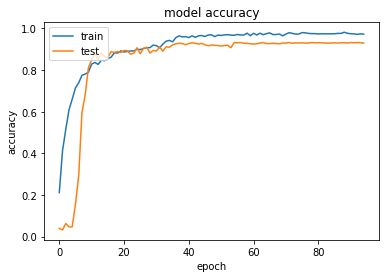

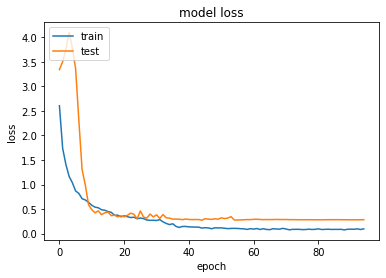

In [17]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

1960/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 1s 314us/sample - loss: 0.0107 - acc: 0.9944


840/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 99.44%
Accuracy on test set: 93.21%


In [20]:
Y_pred = model.predict(X_test_1)
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

IndexError: list index out of range

In [ ]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

In [21]:
Y_pred = model.predict(X_test_1)
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

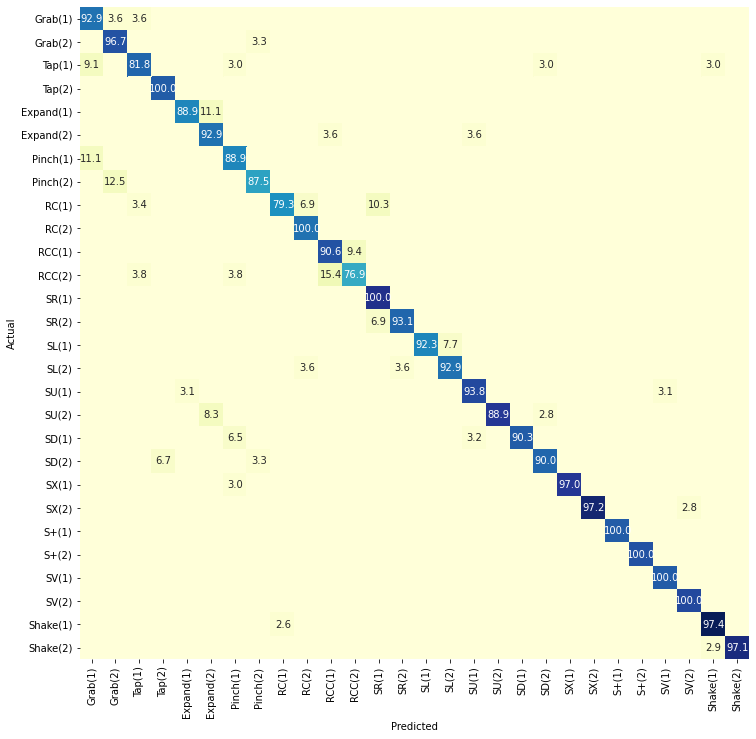

In [22]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_28.png', labels, ymap=None, figsize=(12,12))